# **ASHRAE-Great Energy Predictor III**

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
import category_encoders

from sklearn.impute import SimpleImputer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime

In [ ]:
# Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16
def reduce_mem_usage(data, use_float16=False) -> pd.DataFrame:
    start_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in data.columns:
        if is_datetime(data[col]) or is_categorical_dtype(data[col]):
            continue
        col_type = data[col].dtype

        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.2f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return data

In [ ]:
# Path to data 
PATH = '../input/ashrae-energy-prediction/'

In [ ]:
# Import train data
train = pd.read_csv(f'{PATH}train.csv')
weather_train = pd.read_csv(f'{PATH}weather_train.csv')

# Import metadata
metadata = pd.read_csv(f'{PATH}building_metadata.csv')

In [ ]:
# Remove outliers in train data
train = train[train['building_id'] != 1099]
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [ ]:
# Function for weather data processing
def weather_data_parser(weather_data) -> pd.DataFrame:
    time_format = '%Y-%m-%d %H:%M:%S'
    start_date = datetime.datetime.strptime(weather_data['timestamp'].min(), time_format)
    end_date = datetime.datetime.strptime(weather_data['timestamp'].max(), time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    for site_id in range(16):
        site_hours = np.array(weather_data[weather_data['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list, site_hours), columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_data = pd.concat([weather_data, new_rows], sort=True)
        weather_data = weather_data.reset_index(drop=True)           

    weather_data['datetime'] = pd.to_datetime(weather_data['timestamp'])
    weather_data['day'] = weather_data['datetime'].dt.day
    weather_data['week'] = weather_data['datetime'].dt.week
    weather_data['month'] = weather_data['datetime'].dt.month

    weather_data = weather_data.set_index(['site_id', 'day', 'month'])

    air_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['air_temperature'].median(), columns=['air_temperature'])
    weather_data.update(air_temperature_filler, overwrite=False)

    cloud_coverage_filler = weather_data.groupby(['site_id', 'day', 'month'])['cloud_coverage'].median()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'), columns=['cloud_coverage'])

    weather_data.update(cloud_coverage_filler, overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['dew_temperature'].median(), columns=['dew_temperature'])
    weather_data.update(due_temperature_filler, overwrite=False)

    sea_level_filler = weather_data.groupby(['site_id','day','month'])['sea_level_pressure'].median()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'), columns=['sea_level_pressure'])

    weather_data.update(sea_level_filler, overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_direction'].median(), columns=['wind_direction'])
    weather_data.update(wind_direction_filler, overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_speed'].median(), columns=['wind_speed'])
    weather_data.update(wind_speed_filler, overwrite=False)

    precip_depth_filler = weather_data.groupby(['site_id','day','month'])['precip_depth_1_hr'].median()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'), columns=['precip_depth_1_hr'])

    weather_data.update(precip_depth_filler, overwrite=False)

    weather_data = weather_data.reset_index()
    weather_data = weather_data.drop(['datetime','day','week','month'], axis=1)

    return weather_data

In [ ]:
# Train weather data processing
weather_train = weather_data_parser(weather_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
# Memory optimization
train = reduce_mem_usage(train, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)
metadata = reduce_mem_usage(metadata, use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.18 MB
Decreased by 57.46%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.60 MB
Decreased by 73.08%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.88%


In [ ]:
# Merge train data 
train = train.merge(metadata, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

del weather_train; gc.collect()

0

In [ ]:
# Function for train and test data processing
def data_parser(data) -> pd.DataFrame:
    data.sort_values('timestamp')
    data.reset_index(drop=True)
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
    data['weekday'] = data['timestamp'].dt.weekday
    data['hour'] = data['timestamp'].dt.hour
    
    data['square_feet'] =  np.log1p(data['square_feet']) 
    
    data = data.drop(['timestamp', 'sea_level_pressure',
        'wind_direction', 'wind_speed', 'year_built', 'floor_count'], axis=1)
    
    gc.collect()
    encoder = LabelEncoder()
    data['primary_use'] = encoder.fit_transform(data['primary_use'])
    
    return data

In [ ]:
# Train data processing
train = data_parser(train)

In [ ]:
# Define target and predictors
target = np.log1p(train['meter_reading'])
features = train.drop(['meter_reading'], axis = 1) 

del train; gc.collect()

22

In [ ]:
# Process categorical features
categorical_features = ['building_id', 'site_id', 'meter', 'primary_use']

encoder = category_encoders.CountEncoder(cols=categorical_features)
encoder.fit(features)
features = encoder.transform(features)

features_size = features.shape[0]
for feature in categorical_features:
    features[feature] = features[feature] / features_size

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# Missing data imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(features)
features = imputer.transform(features)

In [ ]:
type(features)

numpy.ndarray

In [ ]:
X_train, X_cv= train_test_split(features, test_size=0.20, shuffle=False)

In [ ]:
y_train, y_cv= train_test_split(target, test_size=0.20, shuffle=False)

In [ ]:
# Import test data
test = pd.read_csv(f'{PATH}test.csv')
weather_test = pd.read_csv(f'{PATH}weather_test.csv')

In [ ]:
row_ids = test['row_id']
test.drop('row_id', axis=1, inplace=True)

In [ ]:
# Test weather data processing
weather_test = weather_data_parser(weather_test)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
# Memory optimization
test = reduce_mem_usage(test, use_float16=True)
weather_test = reduce_mem_usage(weather_test, use_float16=True)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.47 MB
Decreased by 79.10%
Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 5.18 MB
Decreased by 73.08%


In [ ]:
# Merge test data
test = test.merge(metadata, on='building_id', how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

del metadata; gc.collect()

44

In [ ]:
# Test data processing
test = data_parser(test)

test = encoder.transform(test)
for feature in categorical_features:
    test[feature] = test[feature] / features_size

test = imputer.transform(test)

Random Forest

In [ ]:
cv_error_array=[]
lgb_estimators=[75,150,500]
for i in lgb_estimators:
    rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=i, n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
    rf_reg.fit(X_train,y_train)
    pred_rf_reg=rf_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_cv, pred_rf_reg)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_cv, pred_rf_reg)))

rmse for estimators: 75 is 1.7053545141610957
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
rmse for estimators: 150 is 1.6920181010172193
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
rmse for estimators: 500 is 1.6836384519757122


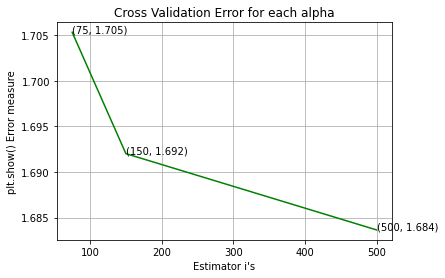

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=lgb_estimators[best_alpha], n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
rf_reg.fit(X_train,y_train)
pred_reg_lgb_cv=rf_reg.predict(X_cv)
pred_reg_lgb_tr=rf_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_train, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, pred_reg_lgb_cv)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Train rmse for estimators: 500 is 1.7031784524136562
CV rmse for estimators: 500 is 1.6836384519757122


In [ ]:
filename_reg='rf_reg.sav'
joblib.dump(rf_reg,filename_reg)

['rf_reg.sav']

In [ ]:
y_pred = rf_reg.predict(test)

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
sample_submission["meter_reading"] =  np.expm1(y_pred)
sample_submission.to_csv("./rf_submission.csv", index=False)

GBDT

In [ ]:
import lightgbm as lgb
lgb_estimators=[75,150,500]
cv_error_array=[]
for i in lgb_estimators:
    lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i,objective='rmse', n_jobs=-1)
    lgb_reg.fit(X_train,y_train)
    pred_reg_lgb=lgb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_cv, pred_reg_lgb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_cv, pred_reg_lgb)))

rmse for estimators: 75 is 1.3117684956117592
rmse for estimators: 150 is 1.2229845100192143
rmse for estimators: 500 is 1.1127266930612176


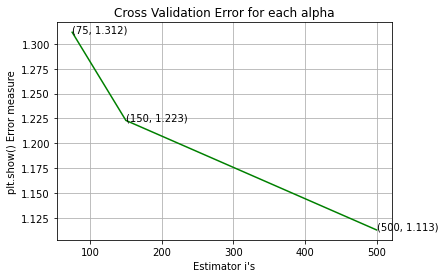

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=lgb_estimators[best_alpha], objective='rmse',n_jobs=-1)
lgb_reg.fit(X_train,y_train)
pred_reg_lgb_cv=lgb_reg.predict(X_cv)
pred_reg_lgb_tr=lgb_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_train, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, pred_reg_lgb_cv)))

Train rmse for estimators: 500 is 1.0429949011063055
CV rmse for estimators: 500 is 1.1127266930612176


In [ ]:
filename_reg='lgb_reg.sav'
joblib.dump(lgb_reg,filename_reg)

['lgb_reg.sav']

In [ ]:
y_pred = lgb_reg.predict(test)

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
sample_submission["meter_reading"] =  np.expm1(y_pred)
sample_submission.to_csv("./gbdt_submission.csv", index=False)

Decision Tree

In [ ]:
cv_error_array=[]
depth=[3,5,7,9,11]
for i in depth:
  dt_reg=DecisionTreeRegressor(max_depth=i)
  dt_reg.fit(X_train,y_train)
  pred_d_reg=dt_reg.predict(X_cv)
  cv_error_array.append(math.sqrt(mean_squared_error(y_cv, pred_d_reg)))
  print("rmse for max_depth:", i,'is',math.sqrt(mean_squared_error(y_cv, pred_d_reg)))

rmse for max_depth: 3 is 1.8388807800814189
rmse for max_depth: 5 is 1.7838711978785249
rmse for max_depth: 7 is 1.6881468329193146
rmse for max_depth: 9 is 1.5734313590601616
rmse for max_depth: 11 is 1.4593513318163778


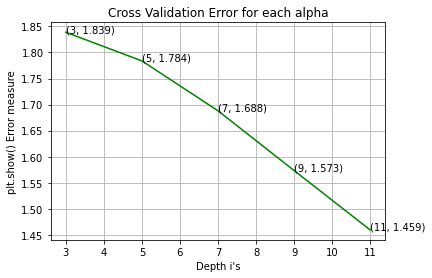

In [ ]:
#this plottig is taken from the personalised cancer diagnosis case study
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(depth, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((depth[i],np.round(txt,3)), (depth[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Depth i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
dt_reg=DecisionTreeRegressor(max_depth=depth[best_alpha],random_state=5)
dt_reg.fit(X_train,y_train)
pred_d_reg_tr=dt_reg.predict(X_train)
pred_d_reg_cv=dt_reg.predict(X_cv)
print("Train rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_train, pred_d_reg_tr)))
print("CV rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, pred_d_reg_cv)))

Train rmse for max_depth: 11 is 1.4159019883735708
CV rmse for max_depth: 11 is 1.459295804322201


In [ ]:
filename_reg='dt_reg.sav'
joblib.dump(dt_reg,filename_reg)

['dt_reg.sav']

In [ ]:
y_pred = dt_reg.predict(test)

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
sample_submission["meter_reading"] =  np.expm1(y_pred)
sample_submission.to_csv("./dt_submission.csv", index=False)

In [1]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model","RMSE"]
summary.add_row(["LightGBM RF",1.68])
summary.add_row(["LightGBM GBDT",1.11])
summary.add_row(["DT",1.45])
print(summary)

+---------------+------+
|     Model     | RMSE |
+---------------+------+
|  LightGBM RF  | 1.68 |
| LightGBM GBDT | 1.11 |
|       DT      | 1.45 |
+---------------+------+


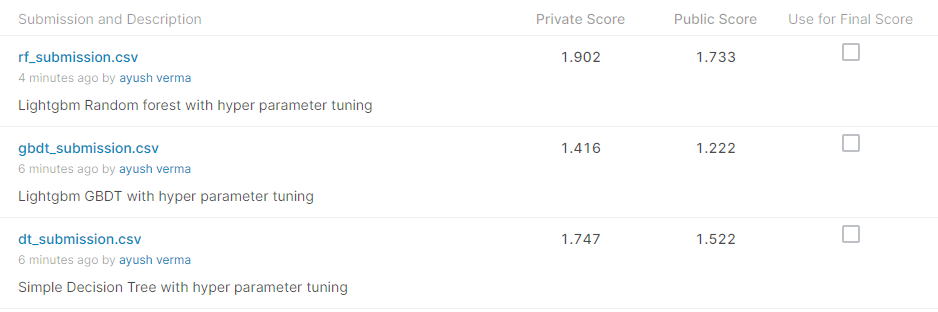

In [2]:
from IPython.display import Image
Image(filename='/content/RF_GBDT_DT_MODELS.PNG')

Summary
1. I impute weather data with mean and median
2. I imput the the remaining missing values with SimpleImputer with median
3. Very basic FE because of the ram problem and also i seen in the lightgb gbdt that raw features are the most important fetaures 
4. Remove outlier
5. Do standardisation on train and test
6. This file run on kaggle notebook please don't try to run on the google colab because of the limited ram


### Refrences
1. https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
2. https://contrib.scikit-learn.org/category_encoders/count.html